In [ ]:
# Imports & readDataSubset()
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import font_manager as fm

# # Load fonts
# font_path = r"C:"
# fm.fontManager.addfont(font_path)
# plt.rcParams['font.family'] = 'Helvetica'

# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [7]:
"""CatchResults.ipynb
Filter for all catch attempts
    Using Contests.ipynb
Get catch results: (contest_catch_results.csv)
    Result labels in probabilities:
        (CatchOn:  Caught while touching 1st base) (Always safe/out)
        (CatchOff: Caught but not touching 1st) (Always safe/out)
        (Dropped:  Uncaught but ball remains near target) (Always safe)
        (Passed:   Ball passed target) (Always safe/advanced)
    If Catch, 
        Store runner position at Catch timestamp (i.e. ft_til_1st)
        Store Catch location
    If CatchOn,
        Pr(Safe|ft_til_1st) 

1. Filter all throws for all contest throws at 1st base
    (Only throws to 1st; not previous in sequence)
    Using contest_throws.csv (Contests.ipynb)
2. Get runner_position_at_catch
    (Distance from 1st base)
    Using player_pos
3. Filter throws for "definitely" CatchOn (for logistic regression)
    Using ball_pos
4. Get Pr(safe|runner_position_at_catch) for "definitely" CatchOn
    (Logistic regression)
    Using contest_results.csv (Contests.ipynb)
5. Label caught throws with CatchOn/CatchOff (also Passed)
    Using Pr(safe|runner_position_at_catch)
    (Safe despite low probability is likely because not touching 1st base)
6. Label uncaught throws with Dropped/Passed
7. Combine
"""
pass

In [8]:
"""
Filter all throws for all contest throws at 1st base
    (Only throws to 1st; not previous in sequence)
    (Get order in sequence)
    Using contest_throws.csv (Contests.ipynb)
"""
contests_thr = pd.read_csv('../CSV/contest_throws.csv')

contests_thr = contests_thr[contests_thr['target_base']=="first"]
contests_thr = contests_thr.sort_values(['game_str','play_id'])
contests_thr.head(1)

,game_str,play_id,thr_ts,acq_ts,arr_ts,target_base,nth_throw
1,y1_d001_CGA_QEA,21,563799,563149.0,564699.0,first,2


In [9]:
"""
Get runner_position_at_catch
    (Distance from 1st base)
    Using player_pos

    We define 'Distance from 1st base' as orthogonal distance from
    given point(player_pos) and a line going through 1st & 2nd base
    (i.e. points (63.64,63.64) and (0, 127.28))

    Equivalently, define a line (1-dimensional axis) that goes through
    home plate & 1st base (i.e. points (0,0) and (63.64,63.64)).
    Project all points(player_pos) onto the axis.
    'Distance from 1st base' is the difference between a given point and 
    point=90 on that axis.
"""
runpos = player_position_subset.to_table(
    filter=pads.field('player_position')==10,
    columns=['game_str','play_id','timestamp','field_x','field_y']
).to_pandas()
# Merge
runpos = pd.merge(contests_thr,runpos,how="left",left_on=['game_str','play_id','arr_ts'],right_on=['game_str','play_id','timestamp'])

# Line through (x1,y1) and (x2,y2) has equation
#   Ax + By + C = 0
#   (y1-y2)x + (x2-x1)y + (x1y2-x2y1) = 0
#   (63.64-127.28)x + (0-63.64)y + 63.64(127.28) = 0
#   A = -63.64, B = -63.64, C = 8100.
# Perpendicular distance:
#   d = (Ax0 + By0 + C) / sqrt(A²+B²)

# Calculate distance from 1st base
denom = np.sqrt((-63.64)**2 + (-63.64)**2)
runpos['ft_til_1st'] = -63.64 * runpos['field_x'] + -63.64 * runpos['field_y'] + 8100.099
runpos['ft_til_1st'] = runpos['ft_til_1st'] / denom

# Cleanup
runpos = runpos[['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw','ft_til_1st']]
runpos.head(1)

,game_str,play_id,thr_ts,acq_ts,arr_ts,target_base,nth_throw,ft_til_1st
0,y1_d001_CGA_QEA,21,563799,563149.0,564699.0,first,2,-1.802771


In [10]:
"""
Filter throws for "definitely" CatchOn (for logistic regression)
(CatchOn: Caught while touching 1st base)
    Using player_pos and ball_pos
    1. Make sure it was a catch
    2. Make sure catcher was within 3ft of 1st base and in fair territory
    3. Make sure catch was within 6ft of 1st base and in fair territory
"""
# Get player_position at catch
playerpos = player_position_subset.to_table(columns=['game_str','play_id','timestamp','player_position','field_x','field_y']).to_pandas()
filtcatch = pd.merge(contests_thr,playerpos,how="left",left_on=['game_str','play_id','arr_ts'],right_on=['game_str','play_id','timestamp'])
filtcatch = filtcatch.rename(columns={"field_x":"ball_catcher_x","field_y":"ball_catcher_y"})
filtcatch = filtcatch.drop(columns='timestamp')
# Get ball_position at catch
ballpos = ball_position_subset.to_table(columns=['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']).to_pandas()
filtcatch = pd.merge(filtcatch,ballpos,how="left",left_on=['game_str','play_id','arr_ts'],right_on=['game_str','play_id','timestamp'])
filtcatch = filtcatch.rename(columns={"ball_position_x":"ball_catch_x","ball_position_y":"ball_catch_y","ball_position_z":"ball_catch_z"})
filtcatch = filtcatch.drop(columns='timestamp')

## 1. Make sure it was a catch
catch = game_events_subset.to_table(
    filter=pads.field('event_code') == 2,columns=['game_str','play_id','timestamp','player_position']).to_pandas()
filtcatch = pd.merge(filtcatch,catch,how="inner",left_on=['game_str','play_id','arr_ts','player_position'],right_on=['game_str','play_id','timestamp','player_position'])
print("Num. contests at 1st: ", len(contests_thr))
print("Num. caught contests: ", len(filtcatch))

## 2. Make sure catcher was within 2.5ft of 1st base and in fair territory
filtcatch['catcher_dist'] = np.sqrt((filtcatch['ball_catcher_x'] - 63.64)**2 + (filtcatch['ball_catcher_y'] - 63.64)**2)
SURE_CATCHER = 3.0

## 3. Make sure catch was within 6ft of 1st base and in fair territory
filtcatch['catch_dist'] = np.sqrt((filtcatch['ball_catch_x'] - 63.64)**2 + (filtcatch['ball_catch_y'] - 63.64)**2)
SURE_CATCH = 7.0

# Apply
defcatch = filtcatch[((filtcatch['catcher_dist'] <= SURE_CATCHER) & 
                      (filtcatch['ball_catcher_y'] > filtcatch['ball_catcher_x']))]
print("Num. definite CatchOn: ", len(defcatch))
defcatch = defcatch[((defcatch['catch_dist'] <= SURE_CATCH) & 
                     (defcatch['ball_catch_y'] > defcatch['ball_catch_x']))]
print("Num. definite CatchOn: ", len(defcatch))

# Merge with runpos
defcatch = pd.merge(runpos,defcatch,how="inner",on=['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw'])

defcatch.head(1)

Num. contests at 1st:  3787
Num. caught contests:  3695
Num. definite CatchOn:  1772
Num. definite CatchOn:  1622


,game_str,play_id,thr_ts,acq_ts,arr_ts,target_base,nth_throw,ft_til_1st,player_position,ball_catcher_x,ball_catcher_y,ball_catch_x,ball_catch_y,ball_catch_z,timestamp,catcher_dist,catch_dist
0,y1_d001_CGA_QEA,26,719299,718549.0,719949.0,first,1,12.778549,3,60.9951,64.8333,61.0761,62.1651,3.86421,719949,2.901631,2.957856


len(contests_defcatch):  1622
len(contests_defcatch):  1615

Confusion Matrix:
 [[464   0]
 [  3  18]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       464
         1.0       1.00      0.86      0.92        21

    accuracy                           0.99       485
   macro avg       1.00      0.93      0.96       485
weighted avg       0.99      0.99      0.99       485


Coefficient for 'ft_til_1st': -1.3388
  → Every one-unit increase in ft_til_1st multiplies odds of safe=1 by 0.2622


c:\Users\mla21\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


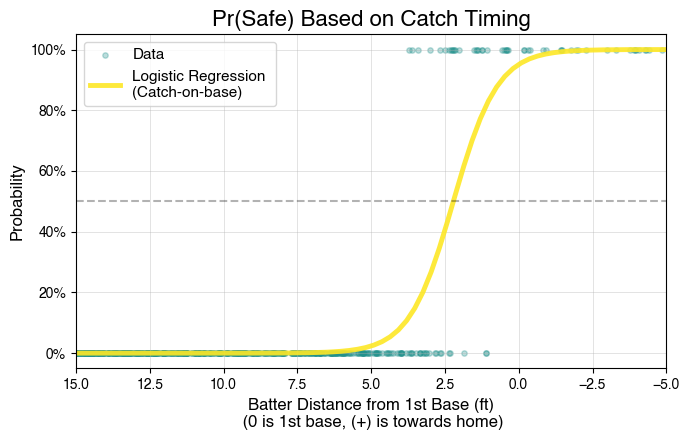

In [13]:
"""
Get Pr(safe|runner_position_at_catch) for "definitely" CatchOn
    (Logistic regression)
    Using contest_results.csv (Contests.ipynb)
    1. Clean data
    2. Prepare logistic regression
    3. Fit
    4. Evaluate
"""
from matplotlib.ticker import PercentFormatter
# Load contest_results (Safe/Out)
contest_results = pd.read_csv('../CSV/contest_results.csv')
# Merge with "definitely" CatchOn
contests_defcatch = pd.merge(contest_results,defcatch,how="right",on=['game_str','play_id'])
print("len(contests_defcatch): ",len(contests_defcatch))

## 1. Clean data
# Debugging
    # temp = contests_defcatch.sort_values('ft_til_1st',ascending=False)
    # temp = temp[temp['safe']==True]
    # plt.figure(figsize=(8,5))
    # temp['ft_til_1st'].hist(bins=30)
# Remove rows with ft_til_1st (outliers; likely mislabel)
# (It's overwhelmingly unlikely that the batter was 5ft before 1st base at catch_timestamp yet safe)
contests_defcatch = contests_defcatch[~((contests_defcatch['ft_til_1st'] > 5.0) & (contests_defcatch['safe']==True))]
# Remove NaN
contests_defcatch = contests_defcatch.dropna(subset=['ft_til_1st'])
print("len(contests_defcatch): ",len(contests_defcatch))

## 2. Prepare logistic regression
contests_defcatch['safe_int'] = contests_defcatch['safe'].astype('Int64')
X = contests_defcatch[['ft_til_1st']]
y = contests_defcatch['safe_int']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 3. Fit
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
# Save model
import pickle
with open('../Models/safe_probability_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

## 4. Evaulate
y_pred = clf.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Interpretation
coef = clf.coef_[0][0]
odds_ratio = np.exp(coef)
print(f"\nCoefficient for 'ft_til_1st': {coef:.4f}")
print(f"  → Every one-unit increase in ft_til_1st multiplies odds of safe=1 by {odds_ratio:.4f}")
# Visualization
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
x_vals_simul = np.linspace(X['ft_til_1st'].min(), X['ft_til_1st'].max(), 300).reshape(-1, 1) 
y_probs = clf.predict_proba(x_vals_simul)[:, 1]  # Predict probability (not class) for smooth curve
plt.figure(figsize=(7, 4.5)) 
plt.scatter(X['ft_til_1st'], y, alpha=0.3, label='Data', s=15, color=colors[1]) 
plt.plot(x_vals_simul, y_probs, linewidth=3.5, alpha=0.9, color=colors[2], label='Logistic Regression \n(Catch-on-base)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.xlim(-5,15)
plt.gca().invert_xaxis()
plt.xlabel("Batter Distance from 1st Base (ft)\n (0 is 1st base, (+) is towards home)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Pr(Safe) Based on Catch Timing", fontsize=16)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3)
plt.legend(fontsize=11)
plt.grid(True, lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
"""
Label caught throws with CatchOn/CatchOff (also Passed)
    Using Pr(safe|runner_position_at_catch)
    (Safe despite low probability is likely because not touching 1st base)
    1. Label "definitely" CatchOn
    2. For other throws, predict Pr(safe|runner_position_at_catch)
    3. Label other caught throws
        Pr(Dropped) = 0%
        If ball_catch_x/y > 80ft:
            Pr(Passed) = 100%
        Else: 
            Pr(Passed) = 0%
            If dist(ball_catch_x/y,1st_base) > 9.5ft:
                Pr(CatchOn) = 0%
                Pr(CatchOff) = 100%
            Else:
                If out:
                    Pr(CatchOn) = 100%
                    Pr(CatchOff) = 0%
                If safe:
                    Pr(CatchOn) = Pr(Safe)
                    Pr(CatchOff) = Pr(Out)
                    (If probability out == 10% and the runner was safe, 
                    then the probability that foot was off is 10%)
        (Assumption: Nobody has standing reach greater than 9.5ft)
        (Assumption: Umpire always makes the correct call)
        (Assumption: All runners have the same stride length)
        (Assumption: Head-first sliding never happens)
    4. Combine
    5. Fix mislabels (manually)
"""
# See step 3 (defcatch)
leave = defcatch[['game_str','play_id','arr_ts']]
tmp = filtcatch.merge(leave,on=['game_str','play_id','arr_ts'],how='left',indicator=True)
indefcatch = tmp[tmp['_merge'] == 'left_only'].drop(columns=['_merge'])
print("len(filtcatch) == len(defcatch) + len(indefcatch): ", len(filtcatch) == len(defcatch) + len(indefcatch))
# Merge with runpos (like defcatch)
indefcatch = pd.merge(runpos,indefcatch,how="inner",on=['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw'])
contests_indefcatch = pd.merge(contest_results,indefcatch,how="right",on=['game_str','play_id'])
# Same as step 3
contests_indefcatch = contests_indefcatch[~((contests_indefcatch['ft_til_1st'] > 5.0) & (contests_indefcatch['safe']==True))]
contests_indefcatch = contests_indefcatch.dropna(subset=['ft_til_1st'])
print("len(filtcatch): ",len(filtcatch))
print("len(contests_defcatch): ",len(contests_defcatch))
print("len(contests_indefcatch): ",len(contests_indefcatch))
print("Few outliers removed (see step 4)")

## 1. Label "definitely" CatchOn
contests_defcatch[['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [1.0, 0.0, 0.0, 0.0]
X = contests_defcatch[['ft_til_1st']]
contests_defcatch[['pr_Out', 'pr_Safe']] = clf.predict_proba(X)

## 2. For other throws, predict Pr(safe|runner_position_at_catch)
X = contests_indefcatch[['ft_til_1st']]
contests_indefcatch[['pr_Out', 'pr_Safe']] = clf.predict_proba(X)

## 3. Label other caught throws
def label_other_caught_throws(row):
    if row['ball_catch_x'] > 80 or row['ball_catch_y'] > 80:
        return pd.Series([0.0, 0.0, 0.0, 1.0], 
                         index=['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed'])
    else:
        if row['catch_dist'] > 9.5:
            return pd.Series([0.0, 1.0, 0.0, 0.0], index=['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed'])
        else:
            if row['safe'] == False:
                return pd.Series([1.0, 0.0, 0.0, 0.0], index=['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed'])
            else:
                return pd.Series([row['pr_Safe'],row['pr_Out'],0.0,0.0], index=['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed'])
# Apply
contests_indefcatch[['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = (
    contests_indefcatch.apply(label_other_caught_throws, axis=1))

## 4. Combine
# We're actually going to keep pr_Out and pr_Safe
# contests_indefcatch = contests_indefcatch.drop(columns=['pr_Out','pr_Safe'])
contests_defcatch_cc = contests_defcatch.drop(columns=['safe_int'])
contests_catch = pd.concat([contests_defcatch_cc,contests_indefcatch],ignore_index=True)

## 5. Fix mislabels (manually)
contests_catch.loc[(contests_catch['game_str']=='y1_d073_PHS_RZQ')&(contests_catch['play_id']==176),
         ['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [1.0, 0.0, 0.0, 0.0]  # Mislabeled catch as deflection

contests_catch.head(1)

len(filtcatch) == len(defcatch) + len(indefcatch):  True
len(filtcatch):  3695
len(contests_defcatch):  1615
len(contests_indefcatch):  2015
Few outliers removed (see step 4)


,game_str,play_id,safe,advanced,thr_ts,acq_ts,arr_ts,target_base,nth_throw,ft_til_1st,...,ball_catch_z,timestamp,catcher_dist,catch_dist,pr_CatchOn,pr_CatchOff,pr_Dropped,pr_Passed,pr_Out,pr_Safe
0,y1_d001_CGA_QEA,26,False,False,719299,718549.0,719949.0,first,1,12.778549,...,3.86421,719949,2.901631,2.957856,1.0,0.0,0.0,0.0,0.999999,7.197045e-07


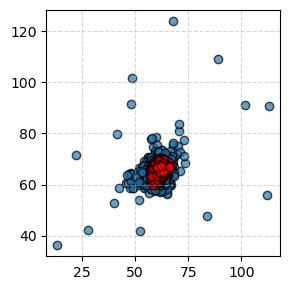

In [9]:
plt.figure(figsize=(3,3))
plt.scatter(contests_indefcatch['ball_catch_x'], contests_indefcatch['ball_catch_y'], alpha=0.7, edgecolor='k')
plt.scatter(contests_defcatch['ball_catch_x'], contests_defcatch['ball_catch_y'], alpha=0.7, edgecolor='k',color='red')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:
"""
Label uncaught throws with Dropped/Passed
    1. Filter for uncaught throws
    2. Track uncaught throws for (up to) 2000ms since first deflection
    3. Label uncaught throws
        If ball stays within 10ft from 1st base (in 2D space)
            And ball stays within infield, Dropped
            (Define a smaller infield arc)
            (See Appendix)
        Else, Passed
    4. Fix mislabels (manually)
"""
## 1. Filter for uncaught throws
# See step 3
leave = filtcatch[['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw']]
tmp = contests_thr.merge(leave,how="left",on=['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw'],
                         indicator=True)
notcatch = tmp[tmp['_merge'] == 'left_only'].drop(columns=['_merge'])
print("len(contests_thr) == len(filtcatch) + len(notcatch): ", len(contests_thr) == len(filtcatch) + len(notcatch))
print("len(notcatch): ", len(notcatch))

## 2. Track uncaught throws for (up to) 2000ms since first deflection
ballpos = ball_position_subset.to_table(columns=['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']).to_pandas()
notcatch = pd.merge(notcatch,ballpos,how="left",left_on=['game_str','play_id'],right_on=['game_str','play_id'])
notcatch = notcatch[((notcatch['timestamp'] >= notcatch['arr_ts']) & 
                             (notcatch['timestamp'] <= notcatch['arr_ts'] + 2000))]

## 3. Label uncaught throws
from Helpers import is_in_infield
ARCSIZE = 71.5
notcatch['in_infield'] = notcatch.apply(lambda row: is_in_infield(
    x=row['ball_position_x'], y = row['ball_position_y'], scale=ARCSIZE), axis=1)
notcatch['d_from1st'] = np.sqrt((notcatch['ball_position_x']-63.64)**2 + (notcatch['ball_position_y']-63.64)**2)

notcatch = notcatch.groupby(['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw']).agg(
    d_from1st_max = ('d_from1st', 'max'),
    in_infield = ('in_infield', 'all'),
    ball_land_x = ('ball_position_x', 'first'),
    ball_land_y = ('ball_position_y', 'first')
    )
# Helper
def label_uncaught_throws(row):
    if row['d_from1st_max'] > 10.0 and row['in_infield']==False:
        return pd.Series([0.0, 0.0, 0.0, 1.0], index=['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed'])
    else:
        return pd.Series([0.0, 0.0, 1.0, 0.0], index=['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed'])
# Apply
notcatch[['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = (
    notcatch.apply(label_uncaught_throws, axis=1))

# Merge with runpos (like catch)
notcatch = pd.merge(runpos,notcatch,how="inner",on=['game_str','play_id','thr_ts','acq_ts','arr_ts','target_base','nth_throw'])
contests_notcatch = pd.merge(contest_results,indefcatch,how="right",on=['game_str','play_id'])
# Merge with contest_results (Safe/Out)
contest_results = pd.read_csv('../CSV/contest_results.csv')
contests_notcatch = pd.merge(contest_results,notcatch,how="right",on=['game_str','play_id'])
print("len(contests_notcatch): ",len(contests_notcatch))

## 4. Fix mislabels (manually)
# contests_notcatch[contests_notcatch['safe']==False]
nrem = 0
temp = contests_notcatch # for brevity
temp.loc[(temp['game_str']=='y1_d015_IXC_QEA')&(temp['play_id']==153),
         ['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [1.0, 0.0, 0.0, 0.0]  # Mislabeled catch as deflection
temp.loc[(temp['game_str']=='y1_d060.5_JNJ_QEA')&(temp['play_id']==158),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d044_WJU_QEA')&(temp['play_id']==184),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d045_WJU_QEA')&(temp['play_id']==40),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d096_XAX_QEA')&(temp['play_id']==4),
         ['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [1.0, 0.0, 0.0, 0.0]  # Mislabeled catch as deflection
temp = temp[~((temp['game_str'] == 'y2_d004_BEJ_RZQ') & (temp['play_id'] == 106))] # Remove
nrem += 1
temp.loc[(temp['game_str']=='y1_d036_HMN_RZQ')&(temp['play_id']==150),
         ['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [1.0, 0.0, 0.0, 0.0]  # Mislabeled catch as deflection
temp = temp[~((temp['game_str'] == 'y2_d057_IAK_RZQ') & (temp['play_id'] == 260))] # Remove
nrem += 1
temp.loc[(temp['game_str']=='y2_d029_IKJ_RZQ')&(temp['play_id']==5),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d058_KJH_RZQ')&(temp['play_id']==100),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y2_d070_RDO_RZQ')&(temp['play_id']==120),
         ['safe']] = True  # Overrun
temp = temp[~((temp['game_str'] == 'y1_d064_UEX_RZQ') & (temp['play_id'] == 112))] # Remove
nrem += 1
temp.loc[(temp['game_str']=='y1_d065_UEX_RZQ')&(temp['play_id']==177),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d086_DYE_YJD')&(temp['play_id']==165),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y2_d090_NYA_YJD')&(temp['play_id']==174),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d058_WZR_YJD')&(temp['play_id']==227),
         ['safe']] = True  # Overrun
temp.loc[(temp['game_str']=='y1_d038_HMN_RZQ')&(temp['play_id']==18),
         ['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [0.0, 0.0, 0.0, 1.0]  # Ball untracked
temp.loc[(temp['game_str']=='y2_d068_RDO_RZQ')&(temp['play_id']==285),
         ['pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed']] = [0.0, 0.0, 0.0, 1.0]  # Ball untracked
contests_notcatch = temp
print("Num. removed: ", nrem)

len(contests_thr) == len(filtcatch) + len(notcatch):  True
len(notcatch):  92
len(contests_notcatch):  92
Num. removed:  3


22
67


(45.6939, 201.6123, -6.421830000000001, 172.37943)

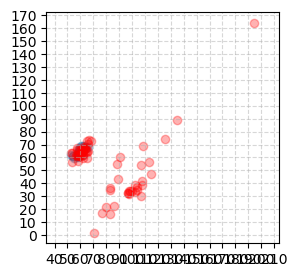

In [11]:
from matplotlib.ticker import MultipleLocator
temp1 = contests_notcatch[contests_notcatch['pr_Dropped']==1]
print(len(temp1))
temp2 = contests_notcatch[contests_notcatch['pr_Dropped']==0]
print(len(temp2))
plt.figure(figsize=(3,3))
plt.scatter(temp1['ball_land_x'], temp1['ball_land_y'], alpha=0.3,)
plt.scatter(temp2['ball_land_x'], temp2['ball_land_y'], alpha=0.3,color='red')
plt.xlim(0,200)
plt.ylim(0,200)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.grid(True, linestyle='--', alpha=0.5, which='major')
plt.axis('equal')

In [ ]:
"""
Combine
"""
# Drop unnecessary columns
print("In contests_notcatch not contests_catch:", set(contests_notcatch.columns) - set(contests_catch.columns))
print("In contests_catch not contests_notcatch:", set(contests_catch.columns) - set(contests_notcatch.columns))
print("\n")
contests_notcatch = contests_notcatch.drop(
    columns=['in_infield','ball_land_y','ball_land_x','d_from1st_max'],
    errors='ignore')
# We're gonna keep ball_catch_x/y/z
contests_catch = contests_catch.drop(
    columns=['player_position','catch_dist','timestamp','ball_catcher_x','ball_catcher_y',
             'catcher_dist','ball_catch_x','ball_catch_y','ball_catch_z'],
    errors='ignore') 

# Concat
contests_catch_results = pd.concat([contests_notcatch, contests_catch], ignore_index=True)

# Rename
contests_catch_results = contests_catch_results.rename(columns={'pr_Out':'pr_Out_ifcatchOn',
                                                                'pr_Safe':'pr_Safe_ifcatchOn'})

In contests_notcatch not contests_catch: {'in_infield', 'ball_land_x', 'd_from1st_max', 'ball_land_y'}
In contests_catch not contests_notcatch: {'catch_dist', 'ball_catch_x', 'ball_catch_z', 'catcher_dist', 'player_position', 'ball_catch_y', 'ball_catcher_y', 'ball_catcher_x', 'pr_Safe', 'timestamp', 'pr_Out'}




In [42]:
crit1 = (contests_catch['pr_CatchOff'] > 0.95) & (contests_catch['safe']==True)
len(contests_catch[crit1]) / len(contests_catch[contests_catch['pr_CatchOff']>0.95])

0.23

In [13]:
"""
Finish
"""
print("Num. contests at 1st:     ", len(contests_thr))
print("Num. labeled contests:    ", len(contests_catch_results))
print("\n")
print("Num. CatchOn:             ", 
      len(contests_catch_results[contests_catch_results['pr_CatchOn']==1]))
print("Num. CatchOff:            ", 
      len(contests_catch_results[contests_catch_results['pr_CatchOff']==1]))
print("Num. CatchOn/Off (prob.): ", 
      len(contests_catch_results[(contests_catch_results['pr_CatchOn']>0.0) & (contests_catch_results['pr_CatchOff']>0.0) ]))
print("Num. Dropped:             ", 
      len(contests_catch_results[contests_catch_results['pr_Dropped']==1]))
print("Num. Passed:              ", 
      len(contests_catch_results[contests_catch_results['pr_Passed']==1]))
print("Do numbers add up:        ", 
      len(contests_catch_results) == len(contests_catch_results[contests_catch_results['pr_CatchOn']==1]) + 
      len(contests_catch_results[contests_catch_results['pr_CatchOff']==1]) + 
      len(contests_catch_results[(contests_catch_results['pr_CatchOn']>0.0) & (contests_catch_results['pr_CatchOff']>0.0) ]) + 
      len(contests_catch_results[contests_catch_results['pr_Dropped']==1]) + 
      len(contests_catch_results[contests_catch_results['pr_Passed']==1]))
print("(Remember some 'Passed' from 'definitely CatchOn')")
print("\n")
tolerance = 1e-8
row_sums = contests_catch_results[['pr_CatchOn', 'pr_CatchOff', 'pr_Dropped', 'pr_Passed']].sum(axis=1)
print("Num. rows with prob. not adding up to 1:", len(contests_catch_results[np.abs(row_sums - 1) > tolerance]))
print("Num. CatchOn/Off with advanced: ", len(contests_catch_results[((contests_catch_results['pr_CatchOn']>0)|(contests_catch_results['pr_CatchOff']>0))& (contests_catch_results['advanced']==True)]))
print("Num. Dropped with Out: ", len(contests_catch_results[(contests_catch_results['pr_Dropped']==1) & (contests_catch_results['safe']==False)]))
print("Num. Dropped with advanced: ", len(contests_catch_results[(contests_catch_results['pr_Dropped']==1) & (contests_catch_results['advanced']==True)]))
print("Num. Passed with Out: ", len(contests_catch_results[(contests_catch_results['pr_Passed']==1) & (contests_catch_results['safe']==False)]))

contests_catch_results = contests_catch_results.sort_values(['game_str', 'play_id'])
contests_catch_results.to_csv('../CSV/contest_catch_results.csv', index=False)
contests_catch_results.head(30)

Num. contests at 1st:      3787
Num. labeled contests:     3719


Num. CatchOn:              3335
Num. CatchOff:             95
Num. CatchOn/Off (prob.):  194
Num. Dropped:              22
Num. Passed:               73
Do numbers add up:         True
(Remember some 'Passed' from 'definitely CatchOn')


Num. rows with prob. not adding up to 1: 0
Num. CatchOn/Off with advanced:  0
Num. Dropped with Out:  0
Num. Dropped with advanced:  0
Num. Passed with Out:  0


,game_str,play_id,safe,advanced,thr_ts,acq_ts,arr_ts,target_base,nth_throw,ft_til_1st,pr_CatchOn,pr_CatchOff,pr_Dropped,pr_Passed,pr_Out_ifcatchOn,pr_Safe_ifcatchOn
1704,y1_d001_CGA_QEA,21,True,False,563799,563149.0,564699.0,first,2,-1.802771,0.995397,0.004603,0.0,0.0,0.004603,9.953973e-01
89,y1_d001_CGA_QEA,26,False,False,719299,718549.0,719949.0,first,1,12.778549,1.000000,0.000000,0.0,0.0,0.999999,7.197045e-07
90,y1_d001_CGA_QEA,136,False,False,5164805,5163655.0,5165855.0,first,1,25.542957,1.000000,0.000000,0.0,0.0,1.000000,2.727146e-14
91,y1_d001_CGA_QEA,138,False,False,5243405,5241605.0,5244255.0,first,1,33.986873,1.000000,0.000000,0.0,0.0,1.000000,3.359472e-19
1705,y1_d001_CGA_QEA,141,False,False,5428705,5427355.0,5429605.0,first,1,20.772108,1.000000,0.000000,0.0,0.0,1.000000,1.620175e-11
92,y1_d001_CGA_QEA,152,False,False,5966419,5965769.0,5967319.0,first,1,12.760093,1.000000,0.000000,0.0,0.0,0.999999,7.377081e-07
93,y1_d001_CGA_QEA,205,False,False,7966380,7965530.0,7967080.0,first,1,13.265392,1.000000,0.000000,0.0,0.0,1.000000,3.750554e-07
94,y1_d001_CGA_QEA,218,False,False,8410080,8408580.0,8410780.0,first,1,12.760942,1.000000,0.000000,0.0,0.0,0.999999,7.368705e-07
1706,y1_d001_CGA_QEA,220,False,False,8587080,8585580.0,8588080.0,first,1,17.955207,1.000000,0.000000,0.0,0.0,1.000000,7.036501e-10
95,y1_d001_CGA_QEA,225,False,False,8705380,8704580.0,8705980.0,first,1,22.180028,1.000000,0.000000,0.0,0.0,1.000000,2.460215e-12
